## 4.5 학습 알고리즘 구현

**전제**

신경망에는 적응 가능한 가중치(W)와 편향(b)이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 '학습'이라고 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.

**1. 미니배치**
- 훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 **미니배치의 손실함수 값을 줄이는 것**이 목표다.

**2. 기울기 산출**
- 미니배치의 손실 함수 값을 줄이기 위해 각 가중치 매개변수의 기울기를 구한다. **기울기는 손실함수의 값을 가장 작게 하는 방향을 제시**한다.

**3. 매개변수 갱신**
- 가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.

**4. 반복**
- 1 ~ 3단계를 반복한다.
    - 데이터를 미니배치로 무작위로 선정하기 때문에 **확률적 경사 하강법(Stochastic Gradient Descent)**이라고 부른다. (확률적으로 골라낸 데이터에서 수행하는 경사하강법)

### 4.5.1 2층 신경망 클래스 구현
- 2층 신경망을 하나의 클래스로 구현해보자.

**필요한 것들**
1. 매개변수 설정
2. 미니배치
3. 예측값 출력
4. 손실함수 생성
5. 손실함수 기울기 산출
6. 매개변수 갱신

입력값에 대한 shape을 미리 알고 있어야 한다.

In [16]:
import sys
sys.path.append("./code/") # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from common.functions import *
from common.gradient import numerical_gradient
import numpy as np

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화, 매개변수 설정
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
    
    def predict(self, x): # 예측값 출력
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t): # 손실함수 생성
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t): # 정확도 계산
        y = self.predict(x)
        y_arg = np.argmax(y, axis=1)
        t_arg = np.argmax(t, axis=1)
        
        accuracy = np.sum(y_arg == t_arg) / float(x.shape[0])
        return accuracy
    
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t): # 손실함수의 기울기 산출
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t): # 매개변수 갱신
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)
        
        return grads

*__TwoLayerNet 클래스가 사용하는 변수__*

|변수|설명|
|:----------|:----------------------------------------------------------:|
|params|신경망의 매개변수를 보관하는 딕셔너리 변수(인스턴스 변수)|
|-|params["W1"]은 1번째 층의 가중치, params['b1']은 1번째 층의 편향|
|grads|기울기 보관하는 딕셔너리 변수(numerical_gradient()매서드의 반환 값|
|-|grads['W1']은 1번째 층의 가중치의 기울기, grads['b2']은 1번째 층의 편향의 기울기|

*__TwoLayerNet 클래스의 메서드__*

|메서드|설명|
|:---------|:------------------------:|
|init(self,...)|input_size:입력층의 뉴런수, hidden_size:은닉층의 뉴런수, output_size:출력층의 뉴런수|
|predict(self,x)|예측(추론)을 수행한다.|
|-|x는 이미지 데이터, t는 정답 레이블|
|loss(self,x,t)|손실 함수의 값을 구한다.|
|accuracy(self, x, t)|정확도를 구한다.|
|numerical_gradient(self, x, t)|가중치 매개변수의 기울기를 구한다.|

> *__np.random.randn(input_size, hidden_size)__*
- 가중치 매개변수를 추출할 때 사용한 함수다. 클래스의 초기화 함수에 존재
- 가중치 매개변수의 초깃값을 무엇으로 설정하느냐가 신경망 학습의 성공을 좌우한다.
- 당장은 정규분포를 따르는 난수로 편향은 0으로 초기화 한다.

In [4]:
net = TwoLayerNet(784, 100, 10)
net.params['W1'].shape

(784, 100)

In [5]:
net.params['b1'].shape

(100,)

In [6]:
net.params['W2'].shape

(100, 10)

- params 변수에는 이 신경망에 필요한 매개변수가 모두 저장된다.
- params 변수에 저장된 가중치 매개변수가 예측처리(순방향 처리)에서 사용된다.
    - 참고로 예측 처리는 다음과 같이 실행할 수 있다.

In [7]:
x = np.random.rand(100, 784)
x

array([[0.7224959 , 0.42969007, 0.19742566, ..., 0.11819217, 0.36319697,
        0.81604435],
       [0.70733411, 0.40888042, 0.15381285, ..., 0.40532318, 0.88769577,
        0.91049957],
       [0.46068766, 0.77769479, 0.73357782, ..., 0.81185506, 0.38432881,
        0.25967102],
       ...,
       [0.64398543, 0.07750777, 0.77840857, ..., 0.78190292, 0.48464855,
        0.55959195],
       [0.3344678 , 0.57688699, 0.3965918 , ..., 0.46397661, 0.43845733,
        0.98873051],
       [0.40356317, 0.49692307, 0.5265339 , ..., 0.818013  , 0.2386327 ,
        0.95404727]])

In [9]:
y = net.predict(x)
y

array([[0.10073148, 0.10648047, 0.09739916, 0.09829687, 0.1028917 ,
        0.09943138, 0.10901998, 0.09997572, 0.09586542, 0.08990784],
       [0.10076785, 0.10590015, 0.0975777 , 0.09851404, 0.10293769,
        0.09947402, 0.10916328, 0.09996861, 0.09606507, 0.08963159],
       [0.10055645, 0.10590541, 0.09756454, 0.09862487, 0.10296259,
        0.09932652, 0.10925786, 0.09955765, 0.09614174, 0.09010238],
       [0.1006969 , 0.10623185, 0.09739052, 0.09816682, 0.10350758,
        0.09940177, 0.10873206, 0.10005991, 0.09600132, 0.08981127],
       [0.10029495, 0.10642168, 0.09742401, 0.09843958, 0.10324857,
        0.0995966 , 0.10887695, 0.0997152 , 0.09596686, 0.0900156 ],
       [0.10090193, 0.10624836, 0.09721796, 0.09826654, 0.10333391,
        0.09958103, 0.1091134 , 0.09990392, 0.09566313, 0.08976982],
       [0.10083544, 0.10620028, 0.09746398, 0.09830515, 0.10329159,
        0.09912397, 0.10876183, 0.09979135, 0.09623508, 0.08999133],
       [0.10044487, 0.10633313, 0.0976108

### 4.5.2 미니배치 학습 구현
- 미니배치 학습이란 훈련 데이터 중 일부를 무작위로 꺼내고(미니배치)
- 미니배치에 대해서 경사법으로 매개변수를 갱신한다.
- TwoLayerNet 클래스와 MNIST 데이터셋을 사용하여 학습을 수행해보자.

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.88105, 0.8861
train acc, test acc | 0.9087166666666666, 0.9129
train acc, test acc | 0.9193, 0.9208
train acc, test acc | 0.92885, 0.9289
train acc, test acc | 0.9351333333333334, 0.9365
train acc, test acc | 0.9399, 0.9393
train acc, test acc | 0.9447666666666666, 0.9453
train acc, test acc | 0.9478, 0.9475
train acc, test acc | 0.9504333333333334, 0.9473
train acc, test acc | 0.95325, 0.9503
train acc, test acc | 0.9551666666666667, 0.9521
train acc, test acc | 0.9580166666666666, 0.9542
train acc, test acc | 0.9592666666666667, 0.9555
train acc, test acc | 0.9618333333333333, 0.9563
train acc, test acc | 0.96295, 0.9574
train acc, test acc | 0.9645166666666667, 0.9587
train acc, test acc | 0.9660166666666666, 0.9603
train acc, test acc | 0.9669333333333333, 0.9603
train acc, test acc | 0.9681333333333333, 0.9615
train acc, test acc | 0.9694666666666667, 0.9626
train acc, test acc | 0.9701833333333333, 0.9624
tr

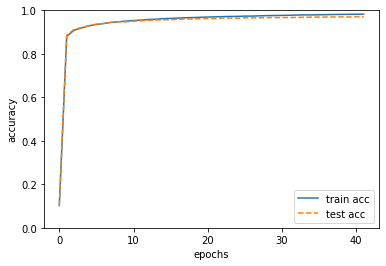

In [25]:
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 25000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.22

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1 에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ("W1", "b1", "W2", "b2"):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1 에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
    

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

- train_loss_list의 값을 이용해 손실함수 값의 추이를 알 수 있다.
    - 학습 횟수가 늘어가면서 손실 함수의 값이 줄어든다.
    - 매개변수가 서서히 데이터에 적응하고 있음을 의미한다.

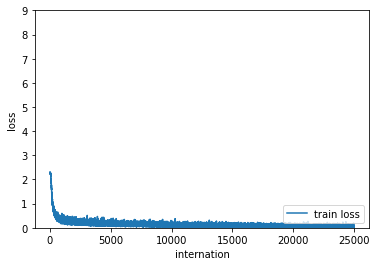

In [26]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel('internation')
plt.ylabel('loss')
plt.ylim(0, 9.0)
plt.legend(loc='lower right')
plt.show()

### 4.5.3 시험 데이터로 평가하기
- 손실함수의 값이란, 정확히는 **훈련 데이터의 미니배치에 대한 손실 함수**를 의미한다.
- 신경망 학습에서는 **훈련 데이터 이외의 데이터**를 올바르게 인식하는 지 확인해야 한다. (`오버피팅 문제`가 발생하는 지 확인해야 한다.)

> **에폭(epoch)**
- 하나의 단위로 1에폭은 학습에서 훈련 데이터를 모두 소진했을 때의 횟수에 해당한다.
- 예를 들어, 10,000개를 100개의 미니배치로 학습할 경우, 확률적 경사 하강법을 100회 반복하면 모든 훈련 데이터를 '소진'하게 된다.
- 이 경우 100회가 1에폭이 된다.